# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [216]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

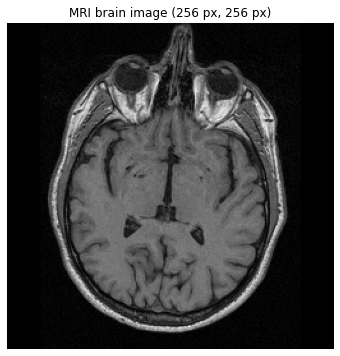

In [217]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

In [218]:
# Add your implementation and discussion



### 1.3 Contour detection (5pts)

In [219]:
# Add your implementation and discussion

### 1.4 Additional method (5pts)

In [220]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [221]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


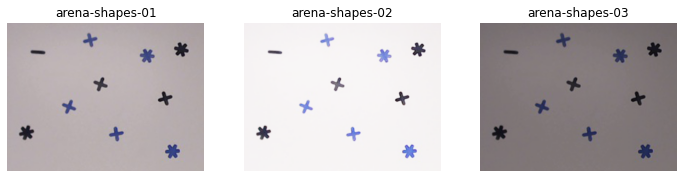

In [222]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

It might be difficult to treat RGB images, this is why we are converting them to grayscale.

In a similar way, we could also convert the images into HSV (hue, saturation, value) and then look at the value component, which basically corresponds to the intensity of the pixel.

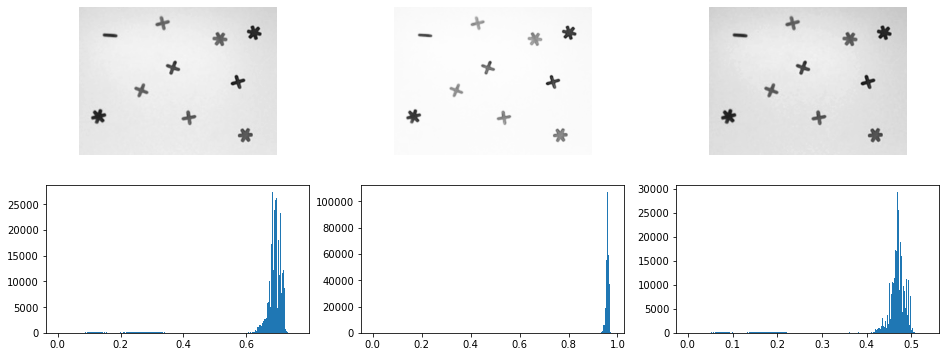

In [223]:
import cv2
from skimage.color import rgb2gray

v_images = np.empty(images.shape[0:3])
fig, axes = plt.subplots(2, 3, figsize=(16,6))
for i, img in enumerate(images):
    v_images[i, :, :] = rgb2gray(img)
    plt.subplot(2, 3, i+1)
    plt.imshow(v_images[i],cmap = 'gray') # in intensity
    plt.axis('off')
    plt.subplot(2,3,i+4)
    plt.hist(v_images[i].flatten(), bins=256)
plt.show()

We can see that the resulting images are the same as before but in grayscale. The histograms shows the distribution of the values of the pixels. We can observe there is a high peak that corresponds to the background pixels. In order to treat the three images the same way, we need to do make these histograms equivalent, and that is why we are using histogram equalization.

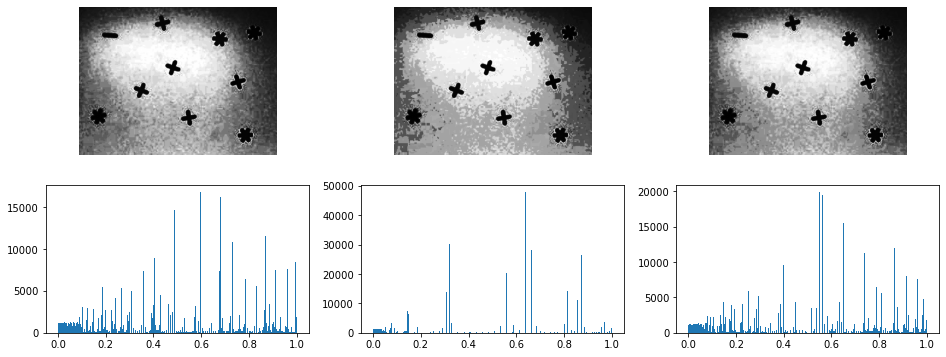

In [224]:
import cv2
# from cv2 import equalizeHist
import numpy as np

from skimage import exposure

eq_images = np.empty(v_images.shape)

fig, axes = plt.subplots(2, 3, figsize=(16,6))
for i, img in enumerate(v_images):
    # eq_images[i, :, :] = cv2.equalizeHist(v_images[i])  # does not work
    eq_images[i, :, :] = exposure.equalize_hist(img)
    plt.subplot(2, 3, i+1)
    plt.imshow(eq_images[i], cmap = 'gray') # in intensity
    plt.axis('off')
    plt.subplot(2,3,i+4)
    plt.hist(eq_images[i].flatten(), bins=256)
plt.show()

After this, we have to choose a threshold to identify the shapes from the background. After some trials, we chose a threshold value of 0.03. If the value of a pixel is above this threshold, it is supposed to belong to the background.

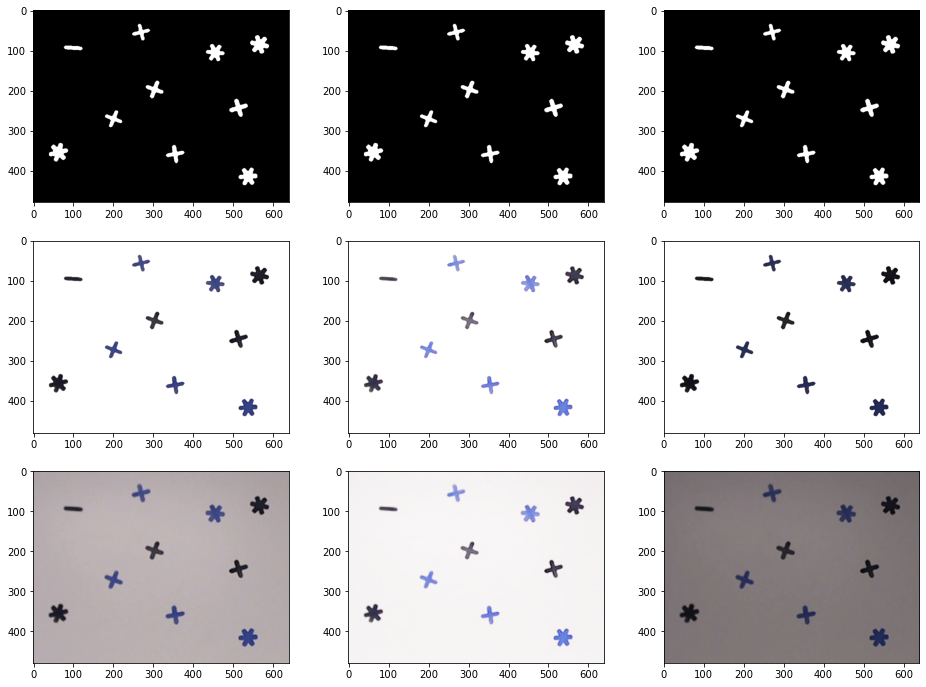

In [225]:
masks = np.empty(eq_images.shape)
no_background = images.copy()
fig, axes = plt.subplots(3, 3, figsize=(16,12))
for i, img in enumerate(eq_images):
    masks[i, :, :] = cv2.threshold(img, 0.03, 1, cv2.THRESH_BINARY_INV)[1]
    plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap = 'gray')
    
    no_background[i][(masks[i]==0)] = 255
    plt.subplot(3, 3, i+4)
    plt.imshow(no_background[i])
    
    plt.subplot(3, 3, i+7)
    plt.imshow(images[i])
plt.show()

We can see that the mask allows us to is treat either only the background or only the shapes. We plot the original images to check that the area covered by the shapes remains the same as we need to compute it for the second task.

Now we can create a gaussian mixture model for each image in order to cluster the pixels depending on their colors, so that we will be able to distinguish the blue shapes from the dark ones.

In [226]:
from sklearn import mixture

g1 = mixture.GaussianMixture(n_components=2).fit((eq_images[0][(masks[0]==1)]).reshape(-1,1))
g2 = mixture.GaussianMixture(n_components=2).fit((eq_images[1][(masks[1]==1)]).reshape(-1,1))
g3 = mixture.GaussianMixture(n_components=2).fit((eq_images[2][(masks[2]==1)]).reshape(-1,1))

g = [g1, g2, g3]

Here, we create a function that returns the eight neighbours of one pixel. We need it for the next function to perform the region growing for one shape.

In [227]:
def get8n(x, y, shape):
    out = []
    if x-1 >= 0 and y-1 >= 0:
        out.append((x-1, y-1) )
    if x-1 >= 0 :
        out.append((x-1, y))
    if x-1 >= 0 and y+1 < shape[1]:
        out.append((x-1, y+1))
    if y-1 >= 0:
        out.append((x, y-1))
    if y+1 < shape[1]:
        out.append((x, y+1))
    if x+1 < shape[0] and y-1 >= 0:
        out.append((x+1, y-1))
    if x+1 < shape[0] :
        out.append((x+1, y))
    if x+1 < shape[0] and y+1 < shape[1]:
        out.append((x+1, y+1))
    return out

In [228]:
def region_growing(img, seed):
    liste = []
    outimg = np.zeros_like(img)

    liste.append((seed[0], seed[1]))
    while(len(liste) > 0):
        pix = liste[0]
        outimg[pix[0], pix[1]] = 1
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] > 0 and outimg[coord[0], coord[1]] == 0:
                outimg[coord[0], coord[1]] = 1
                liste.append((coord[0], coord[1]))
        liste.pop(0)
    return outimg

The next function can count the shapes of each color and also return the area that they cover.

In [229]:
def count_shapes(image, mask, g):
    count = 0
    count1 = 0
    surface1 = 0
    surface2 = 0
    count2 = 0
    temp = mask.copy()
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if temp[i, j] == 1:
                # print((i, j))
                # fig, ax = plt.subplots()
                # plt.imshow(temp, cmap='gray')
                count = count + 1
                one_shape = region_growing(temp, [i, j])
                pred = g.predict(image[one_shape == 1].reshape(-1,1))
                if len(pred[pred==1]) > len(pred[pred==0]):
                    count2 = count2 + 1
                    surface2 = surface2 + len(pred)
                else: 
                    count1 = count1 + 1
                    surface1 = surface1 + len(pred)  
                temp[one_shape == 1] = 0             
    return count, count1, surface1, count2, surface2

In [230]:
for i in range(3):
    print('\nAnalysis of {}'.format(im_names[i]))
    count, count1, surface1, count2, surface2 = count_shapes(eq_images[i], masks[i], g[i])
    print('\nTotal number of shapes: {}'.format(count))
    print('Total number of shapes of first color: {}'.format(count1))
    print('Total area of first color: {}'.format(surface1))
    print('Total number of shapes of second color: {}'.format(count2))
    print('Total area of second color: {}'.format(surface2))


Analysis of arena-shapes-01

Total number of shapes: 10
Total number of shapes of first color: 5
Total area of first color: 4531
Total number of shapes of second color: 5
Total area of second color: 4667

Analysis of arena-shapes-02

Total number of shapes: 10
Total number of shapes of first color: 5
Total area of first color: 4659
Total number of shapes of second color: 5
Total area of second color: 4542

Analysis of arena-shapes-03

Total number of shapes: 10
Total number of shapes of first color: 5
Total area of first color: 4667
Total number of shapes of second color: 5
Total area of second color: 4529


### 2.3 Total area (in pixels) of each color (5 pts)

To compute the total area in pixel for each color, we can use the result of our previous function! We see some really close value wich makes sense as it is three times the same image only with different lighting condition. The variability can come from our thresholding, histogram equalization and our GMM. Maybe other metho 

In [231]:
for i in range(3):
    print('\nAnalysis of {}'.format(im_names[i]))
    count, count1, surface1, count2, surface2 = count_shapes(eq_images[i], masks[i], g[i])
    print('Total area of first color: {}'.format(surface1))
    print('Total area of second color: {}'.format(surface2))


Analysis of arena-shapes-01
Total area of first color: 4531
Total area of second color: 4667

Analysis of arena-shapes-02
Total area of first color: 4659
Total area of second color: 4542

Analysis of arena-shapes-03
Total area of first color: 4667
Total area of second color: 4529
